# drlnd Project 2: Continuous Control, Second Version (20 agents)



https://github.com/sliao-mi-luku/DeepRL-continuous-control-reachers-udacity-drlnd-p2


Reinforcement learning environment by Unity ML-Agents

This corresponds to Project #2 of Udacity's Deep Reinforcement Learning Nanodegree (drlnd)

https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

The deep deterministeic policy gradients (DDPG) method is implemented for this project

**Reference**: this code was inspired by:

1. Udacity's GitHub repository **ddpg-pendulum** (ddpg_agent.py)

   https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum
   
   https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py


2. Udacity's drlnd project workspace (jupyter notebook) of Continuous Control

## Box 1: Starting the environment

Run the box below to import necessary packages.

In the command `env = UnityEnvironment(file_name = '...')` paste the path to `Reacher.exe`

For example: `env = UnityEnvironment(file_name = './Reacher_20Agent_Windows_x86_64/Reacher.exe')`


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque #, namedtuple
from unityagents import UnityEnvironment
from ddpgAgent import DDPG_Agent
from buffer import Buffer
from noiseModels import OUNoise, plot_OU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\nDevice: {}".format(device))


"""
Starting the second version of the project (with 20 agents)
"""
# file_name = /the/path/to/Reacher.exe
env = UnityEnvironment(file_name = './Reacher_20Agent_Windows_x86_64/Reacher.exe')


"""
Environments contain brains which are responsible for deciding the actions of their associated agents
"""
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


"""
The codes below were provided by Udacity, which will display some information of the environment
"""
# reset the environment (train_mode is set to False because we're not training)
env_info = env.reset(train_mode=False)[brain_name]

# number of agents (should be 20)
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action (should be 4)
action_size = brain.vector_action_space_size
print('\nSize of each action:', action_size)
# examine the state space (should be 33)
states = env_info.vector_observations
state_size = states.shape[1]
print('\nThere are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('\nThe state for the first agent looks like:', states[0])


print("\nBox 1 done!")


Device: cuda:0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20

Size of each action: 4

There are 20 agents. Each observes a state with length: 33

The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]

Box 1 done!


## Box 2: Setting parameters

Run this box to set the parameters

In [2]:
EPISODES = 1000                   # maximum number of episodes to train

PRINT_EVERY = 10                  # print a new line of information every 10 episodes


## hyperparameters
actor_hidden_sizes = [400, 300]   # input and output sizes of the actor's hidden FC layer
critic_hidden_sizes = [400, 300]  # input and output sizes of the critic's hidden FC layer
gamma = 0.99                      # discounting
actor_lr = 1e-3                   # learning rate of the actor network
critic_lr = 1e-4                  # learning rate of the critic network
critic_L2_decay = 0.0             # L2 weight decay of the critic network
tau = 1e-3                        # the factor used for soft-updating actor/critic target networks


## parameters of the noise (Ornstein–Uhlenbeck) process
ou_scale = 1.0                    # the initial scaling factor
ou_decay = 0.995                  # the decay rate of the scaling factor ou_scale
ou_mu = 0.0                       # the asymptotic mean of the noise
ou_theta = 0.15                   # the magnitude of the drift term of the noise
ou_sigma = 0.10                   # the magnitude of the diffusion term of the noise


## parameters of the replay buffer
buffer_size = int(1e6)            # the size of the buffer
batch_size = 512                  # the size of the sampling batch


## Dictionary to pass into the DDPG_Agent to create the agent
config = {}
config['actor_input_size'] = 33                         # dimension of the state
config['actor_output_size'] = 4                         # dimension of the action
config['actor_hidden_sizes'] = actor_hidden_sizes
config['critic_state_size'] = 33                        # dimension of the state
config['critic_action_size'] = 4                        # dimension of the action
config['critic_hidden_sizes'] = critic_hidden_sizes
config['actor_lr'] = actor_lr
config['critic_lr'] = critic_lr
config['critic_L2_decay'] = critic_L2_decay
config['gamma'] = gamma
config['tau'] = tau


print("\n Box 2 done!")


 Box 2 done!


## Box 3: Deep Deterministic Policy Gradients (DDPG)

Run this box to train the agent

Simulation of the noise Process:


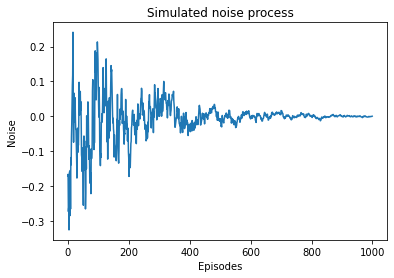



Episode 10	Score: 1.79	Avg: 1.09	A_loss: -0.1077	C_loss: 0.00003851	ou: 0.007
Episode 20	Score: 6.52	Avg: 2.76	A_loss: -0.1587	C_loss: 0.00009646	ou: -0.005
Episode 30	Score: 34.25	Avg: 9.65	A_loss: -0.3326	C_loss: 0.00104628	ou: -0.015
Episode 40	Score: 39.45	Avg: 16.89	A_loss: -0.7009	C_loss: 0.00078859	ou: -0.024
Episode 50	Score: 39.54	Avg: 21.42	A_loss: -1.1397	C_loss: 0.00121415	ou: 0.0082
Episode 60	Score: 39.56	Avg: 24.44	A_loss: -1.6208	C_loss: 0.00043111	ou: 0.0310
Episode 70	Score: 39.44	Avg: 26.59	A_loss: -2.0201	C_loss: 0.00022306	ou: 0.0100
Episode 80	Score: 39.32	Avg: 28.20	A_loss: -2.3019	C_loss: 0.00011532	ou: 0.0101
Episode 90	Score: 38.69	Avg: 29.41	A_loss: -2.5082	C_loss: 0.00006242	ou: -0.006
Episode 100	Score: 39.22	Avg: 30.37	A_loss: -2.6831	C_loss: 0.00008401	ou: -0.000


Environment is solved after 0 episodes


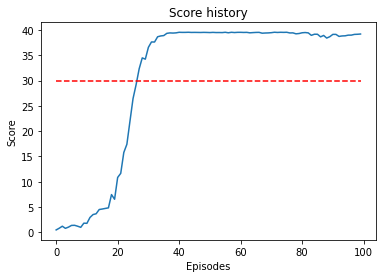

In [3]:
# set ou_scale = 1.0 again in case this box is executed more than once
ou_scale = 1.0


## DDPG
score_deque = deque(maxlen = 100)
score_list = []

AL_list = [] # to store the actor_loss of each episode
CL_list = [] # to store the critic_loss of each episode

# create the replay buffer
buffer = Buffer(buffer_size, batch_size)

# create the ddpg agent
agent = DDPG_Agent(config)

# create the noise process
noise_process = OUNoise(int(num_agents*4), ou_mu, ou_theta, ou_sigma)

print("Simulation of the noise Process:")
plot_OU(EPISODES, ou_scale, ou_decay, 1, ou_mu, ou_theta, ou_sigma)
print("\n")


for ep in range(1, EPISODES+1):
    
    # env information
    env_info = env.reset(train_mode = True)[brain_name]
    # initial states
    states = env_info.vector_observations
    
    score = 0
    t_step = 0
    
    # reset the noise process
    noise_process.reset()
    
    while True:
        t_step += 1
        
        """
        Data collection
        """
        # observe the state (tensor)
        states_t = torch.from_numpy(states).float().to(device)
        
        # generate noise
        noise = noise_process.get_noise().reshape((num_agents, 4)) # [num_agents, 4]
        noise *= ou_scale
        #noise = np.multiply(noise, np.random.choice([1, -1], size = (num_agents, 4)))
            
        # take actions (actions_t is tensor)
        actions_t = agent.act(states_t, actor_name = 'local', noise_bool = True, noise_np = noise) # [num_agents, 4]
        # convert to numpy
        actions = actions_t.detach().cpu().numpy()
        
        # noise_display: the average noise generated
        noise_display = np.round(np.mean(noise), 3)
        
        # interact with the environment
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        
        # add (states, actions, rewards, next_states, dones) into the replay buffer
        for agent_i in range(num_agents):
            buffer.add(states[agent_i], actions[agent_i], rewards[agent_i], next_states[agent_i], dones[agent_i])
        
        # average the rewards among all agents and update the total score
        score += np.mean(np.array(rewards))
        
        # advance to the next state
        states = next_states
        
        
        """
        Policy learning
        """
        # train actor and critic if we have enough replays in the buffer
        if len(buffer) >= batch_size:
            # sample replays
            replays = buffer.sample()
            # train the agent
            agent.learn(replays)
        
        # end the episode if at least one agent is in the terminal state
        if np.any(dones):
            break
    
    
    # record the score (average over agents) of the episode
    score_list.append(score)
    score_deque.append(score)
    
    # average score of the past 100 episodes
    AVG_100 = np.mean(score_deque)
    # actor loss
    aloss = np.round(agent.current_actor_loss, 4)
    # critic loss
    closs = np.round(agent.current_critic_loss, 8)
    
    
    # print the information
    print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\tA_loss: {:.4f}\tC_loss: {:.8f}\tou: {:.3f}".format(
        ep, score, AVG_100, aloss, closs, noise_display), end="")
    
    # print a new line for every PRINT_EVERY epiodes
    if ep % PRINT_EVERY == 0:
        print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\tA_loss: {:.4f}\tC_loss: {:.8f}\tou: {:.3f}".format(
            ep, score, AVG_100, aloss, closs, noise_display))
    
    # the condition when the task is considered solved
    if AVG_100 > 30 and len(score_deque) >= 100:
        print("\n\nEnvironment is solved after {} episodes".format(ep - 100))
        break
    
    
    # update the loss history
    AL_list.append(aloss)
    CL_list.append(closs)
    
    # decrease the scaling factor of the noise
    ou_scale *= ou_decay
    

## Save the weights
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

## Plot the score of each episode
plt.figure()
plt.plot(range(len(score_list)), score_list)
plt.plot([0, len(score_list)-1], [30.0, 30.0], 'r--')
plt.title("Score history")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()


## Box 4: Loading trained weights

Run the box below to use the pre-trained weights to watch the agent perform

Make sure that **Box 1** and **Box 2** was run before running this box!

In [4]:
## Test the saved weights

# create the agent
agent = DDPG_Agent(config)

# load the pre-trained weights from the working directory (change the file name if needed)
actor_weights = torch.load('checkpoint_actor.pth')
critic_weights = torch.load('checkpoint_critic.pth')

# load the pre-trained weights into the agent
agent.actor_local.load_state_dict(actor_weights)
agent.critic_local.load_state_dict(critic_weights)

# initialize the environment
env_info = env.reset(train_mode = False)[brain_name]

# initial state
states = env_info.vector_observations

# score of the episode
score = 0

while True:
    states_t = torch.from_numpy(states).float().to(device)
    actions = agent.actor_local(states_t).cpu().detach().numpy() # converted to ndarray
    env_info = env.step(actions)[brain_name] 
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done 
    score += sum(rewards)/20.0 # average reward over the 20 agents
    states = next_states
    if np.any(dones):
        break
        
print('Total score (averaged over agents) this episode: {:.2f}'.format(score))


Total score (averaged over agents) this episode: 37.86


Lastly, please run the command below to close the environment

In [5]:
env.close()